In [1]:
import sys
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
def _performance(target, predict):
    return (mean_absolute_error(target, predict), mean_squared_error(target, predict), r2_score(target, predict))

def _linearRegressionTrain(Xtrain, ytrain):
    model = linear_model.LinearRegression()
    polymodel = PolynomialFeatures(degree=2).fit(Xtrain)
    Xtrain = polymodel.transform(Xtrain)
    model.fit(Xtrain, ytrain)
    return model, polymodel

def _getTrainingData(Xlearn, ylearn, tscv):
    for trainIndex, validateIndex in tscv:
        Xtrain = Xlearn[trainIndex,:]
        ytrain = ylearn[trainIndex,:]
        Xtest = Xlearn[validateIndex,:]
        ytest = ylearn[validateIndex,:]
        yield trainIndex[-1], Xtrain, ytrain, Xtest, ytest

In [3]:
Xlearn = pd.read_csv("./Data/PreprocessingOutput/Xlearn.csv", header = 0).values
ylearn = pd.read_csv("./Data/PreprocessingOutput/ylearn.csv", header = 0).values

def linearRegressionTrain(Xlearn, ylearn, tscv):
    performance = pd.DataFrame(columns=["Train Index", "MAE train", "MSE train", 
        "R2 train", "MAE test", "MSE test", "R2 test"])
    for trainIndex, Xtrain, ytrain, Xtest, ytest in _getTrainingData(Xlearn, ylearn, tscv):
        model, polymodel = _linearRegressionTrain(Xtrain, ytrain)
        maeTrain, mseTrain, r2Train = _performance(ytrain, model.predict(polymodel.transform(Xtrain)))
        maeTest, mseTest, r2Test = _performance(ytest, model.predict(polymodel.transform(Xtest)))
        performance.loc[len(performance)] = [trainIndex, maeTrain, mseTrain, r2Train, maeTest, mseTest, r2Test]
    return performance

tscv = TimeSeriesSplit(n_splits = 3)
result = linearRegressionTrain(Xlearn, ylearn, tscv.split(Xlearn))
print(result)

   Train Index  MAE train  MSE train  R2 train    MAE test      MSE test  \
0       1749.0   0.017333   0.000519  0.261834  252.087946  3.064497e+06   
1       3499.0   0.017271   0.000526  0.149696    0.026555  1.192081e-03   
2       5249.0   0.015952   0.000485  0.100079    0.063392  8.868770e-03   

        R2 test  
0 -5.732628e+09  
1 -2.148099e+00  
2 -2.360179e+01  


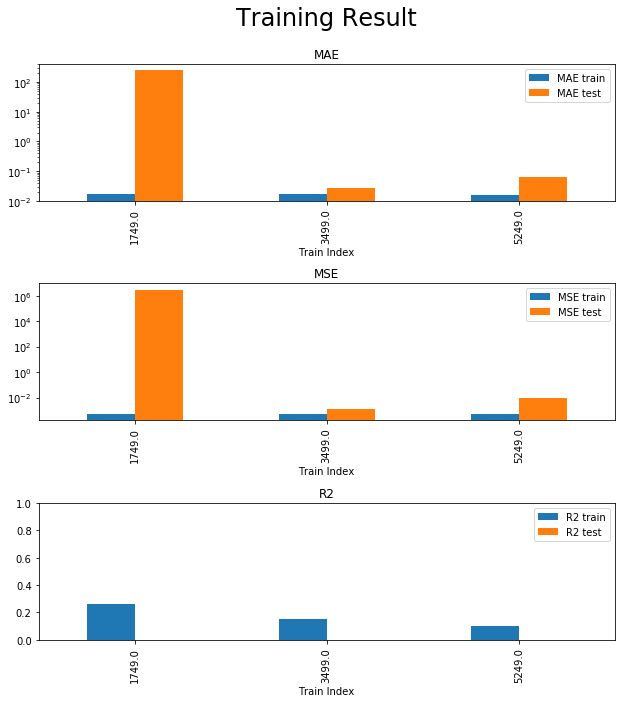

In [4]:
def plotResult(result):
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))
    plt.suptitle("Training Result", fontsize=24)
    plt.subplots_adjust(left=0.1, top=0.9, right=0.9, bottom=0.1, hspace=0.6)
    
    axes[0].set_title("MAE")
    axes[0].set_xlabel("Final train index of fold")
    result[["Train Index", "MAE train", "MAE test"]].plot(x="Train Index", kind="bar", ax=axes[0], logy=True)
    
    axes[1].set_title("MSE")
    axes[1].set_xlabel("Final train index of fold")
    result[["Train Index", "MSE train", "MSE test"]].plot(x="Train Index", kind="bar", ax=axes[1], logy=True)
    
    axes[2].set_title("R2")
    axes[2].set_xlabel("Final train index of fold")
    axes[2].set_ylim(0, 1)
    result[["Train Index", "R2 train", "R2 test"]].plot(x="Train Index", kind="bar", ax=axes[2])
    
plotResult(result)

maeTest = 0.04824757844557669, mseTest = 0.005872301880324884, r2Test = -26.96622860595688


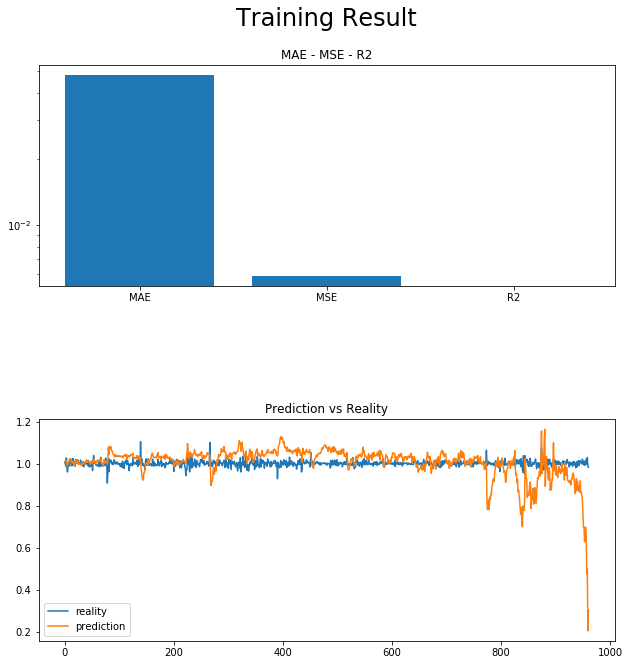

In [27]:
Xtest = pd.read_csv("./Data/PreprocessingOutput/Xtest.csv", header = 0).values
ytest = pd.read_csv("./Data/PreprocessingOutput/ytest.csv", header = 0).values

model, polymodel = _linearRegressionTrain(Xlearn, ylearn)
Xtest = polymodel.transform(Xtest)
ypredict = model.predict(Xtest)
maeTest, mseTest, r2Test = _performance(ytest, ypredict)
print(f"maeTest = {maeTest}, mseTest = {mseTest}, r2Test = {r2Test}")

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
plt.suptitle("Training Result", fontsize=24)
plt.subplots_adjust(left=0.1, top=0.9, right=0.9, bottom=0.1, hspace=0.6)
axes[0].set_title("MAE - MSE - R2")
axes[0].bar([0, 1, 2], [maeTest, mseTest, r2Test], align='center', alpha=1, tick_label = ["MAE","MSE", "R2"], log = True)

axes[1].set_title("Prediction vs Reality")
axes[1].plot(ytest, label = "reality")
axes[1].plot(ypredict, label = "prediction")
axes[1].legend()